In [ ]:
import numpy as np
import pandas as pd

def generate_sample_setting1(p, T, D, seed=1234):
    """Generates data using factor models with 2 factors and a time-varying factor loadings based on step functions
     and residuals from i.i.d multivariate normal distribution with cross-sectional dependence in a synthetic covariance of residuals.
     Copyright (C) 2023 Ali Habibnia <habibnia@vt.edu> & Jalal Etesami

    Args:
      p: Dimension of the portfolio.
      T: Sample size.
      D: The length of each step in the factor loadings.

      The value 200 in T_adjusted is a predefined constant and this value determines the "burn-in" period,
       or the number of initial time steps that are calculated but then discarded when constructing the final time series!

    Returns:
      A (p, T) matrix of asset returns.

    Reference:
      Qingliang Fan, Ruike Wu, Yanrong Yang, Wei Zhong,
      Time-varying minimum variance portfolio,
      Journal of Econometrics,
      2022,
      105339,
      ISSN 0304-4076,
      https://doi.org/10.1016/j.jeconom.2022.08.007.
      (https://www.sciencedirect.com/science/article/pii/S0304407622001646)
    """

    # Seed for reproducibility
    np.random.seed(seed)

    # Adjust T for generating data
    T_adjusted = T + 200

    # Number of steps, common factor intercepts
    k = T_adjusted // D
    muf1 = 0  # Intercept (mean) term for factor 1
    muf2 = 0  # Intercept (mean) term for factor 2

    # Common factors initialization
    f1 = np.zeros(T_adjusted)
    f2 = np.zeros(T_adjusted)

    # Generate common factors f1 and f2
    for t in range(1, T_adjusted):
        # Random disturbances for each factor
        u1_t = np.random.normal(0, np.sqrt(1 - 0.6 ** 2))
        u2_t = np.random.normal(0, np.sqrt(1 - 0.3 ** 2))

        # Update factors with their respective equations
        f1[t] = muf1 + 0.6 * f1[t-1] + u1_t
        f2[t] = muf2 + 0.3 * f2[t-1] + u2_t

    # Stack common factors into matrix for convenience
    F_t = np.vstack([f1, f2])

    # Initialize factor loadings with zeros
    loadings = np.zeros((p, 2, T_adjusted))

    # Generate factor loadings based on the given step function
    for i in range(p):
        # Standard normal random variables for each step
        zi = np.abs(np.random.normal(0, 1, k))
        vi = np.abs(np.random.normal(0, 1, k))

        # Compute factor loadings according to step function
        for t in range(T_adjusted):
            step = t // D
            loadings[i, 0, t] = 2 * zi[0] + sum(zi[1:step + 1])
            loadings[i, 1, t] = 2 * vi[0] + sum(vi[1:step + 1])

    # Assign the computed loadings
    b_it = loadings

    # Initialize returns matrix
    returns = np.zeros((p, T_adjusted))

    # cross-sectional dependence in residuals
    s_cov = np.zeros((p, p))
    for i in range(p):
        for j in range(i + 1, p):
            s_cov[i, j] = ((0.5) ** abs(j - i))
            s_cov[j, i] = s_cov[i, j]
    s_cov = s_cov + np.eye(p)

    # Generate returns for each variable and time period
    for t in range(T_adjusted):
        # Error term from multivariate normal distribution
        e_it = np.random.multivariate_normal(np.zeros(p), s_cov)

        for i in range(p):
            # Combine the common factors, factor loadings, and error terms to generate the sample.
            returns[i, t] = b_it[i, :, t].dot(F_t[:, t]) + e_it[i]

    # We remove the first 200 observations to account for the potential non-stationarity caused by the initial conditions
    returns_df = pd.DataFrame(returns[:, 200:].T, columns=[f'Series_{i+1}' for i in range(p)])

    return returns_df

In [ ]:
# Example usage with specific values for p, T, and D
p = 50
T = 500
D = 50
returns = generate_sample_setting1(p, T, D, seed = 2)
returns.head(3)

,Series_1,Series_2,Series_3,Series_4,Series_5,Series_6,Series_7,Series_8,Series_9,Series_10,...,Series_41,Series_42,Series_43,Series_44,Series_45,Series_46,Series_47,Series_48,Series_49,Series_50
0,5.483996,5.923557,8.426032,7.570904,7.307171,6.049621,10.411288,8.255809,9.535768,4.715898,...,6.708858,6.580257,9.255752,12.453235,6.923982,9.085232,5.033323,5.440299,8.506547,3.669574
1,7.684875,9.755542,11.417728,3.493997,7.161883,5.452640,13.098090,8.594048,10.300633,2.168361,...,4.652637,7.361088,7.883435,13.328962,2.327015,6.567022,1.322635,5.201851,4.701219,0.272709
2,-0.290068,0.179953,-0.435504,-1.052477,-0.517966,0.888099,0.831290,1.146856,-1.520604,-1.103774,...,-0.194581,0.441208,1.122834,1.790632,1.020827,0.914999,0.637676,0.846299,0.501226,0.854669


<Axes: >

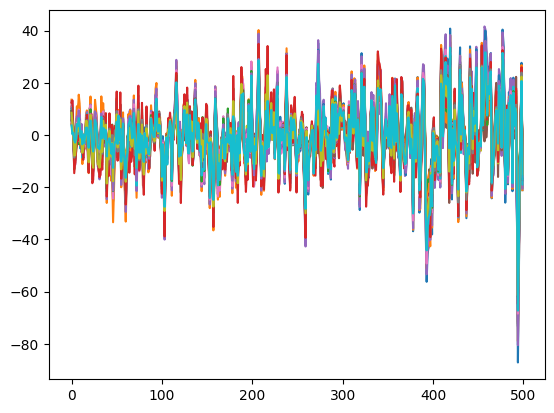

In [ ]:
returns.plot(legend = False)